# QUESTÃO DE NEGÓCIO

**Empresa:**

PCR Covid Tester

**Sobre a Empresa?**

A PCR Covid Tester é uma empresa de biotecnologia que utiliza Inteligência Artificial para predizer se um funcionário de uma outra empresa está com Covid ou não, através de amostras extraídas dentro da própria empresa de origem usando técnica de **Espectroscopia do Infravermelho Próximo (NIR)**.

**Qual o problema de negócio?**

O desafio consiste na construção de um modelo de aprendizado de máquina para realizar a discriminação dos dados espectrais de COVID-19 em relação ao grupo controle.

**Objetivo do desafio?**

Ao final, devem ser apresentados os resultados obtidos explicando os critérios de decisão para a escolha do melhor modelo.

**Sobre os Dados:**

A **espectroscopia do infravermelho próximo (NIR)** é uma técnica experimental que se baseia na utilização da luz para estudar a composição, a estrutura e as propriedades da matéria.
De forma prática, é emitido diversos feixes de luz no material, utilizando diversos
comprimentos de onda no espectro do infravermelho. **Como resultado**, temos a **resposta
dos diferentes comprimentos de onda para cada amostra**.

No total a base de **dados** contém **309 amostras** com **899 colunas**, sendo cada **coluna**
representada pela **quantidade de luz refletida por cada faixa de comprimento de onda**.
**Como rótulo**, existe uma **coluna indicando o resultado do teste RT-PCR para cada amostra**,
tendo **dois rótulos possíveis**: **“Controle”**, para os dados que obtiveram **resultado negativo**
para o **teste RT-PCR**, e a classe **“Covid”**, para as amostras que obtiveram **resultado positivo**
no teste.

**Que tipos de perguntas devemos responder?**

**1)** Quais são as amostras que tiveram **resultado positivo** para o **teste RT-PCR**?

**2)** Quais tiveram **resultado negativo**?

## Planejando a Solução

**O que precisa ser entregue?**

**É importante que seja entregue ao final do desafio todos os códigos utilizados, juntamente
com um pequeno parágrafo descrevendo os resultados obtidos e a metodologia utilizada
para avaliar o desempenho do modelo**

Caso não tenha **tempo suficiente** para implementar todas as técnicas que acharia válido para usar nesse problema, explique quais usaria e **porquê**.

**Qual a solução?**

É preciso desenvolver um modelo de machine learning capaz de classificar as amostras em 2 classes:

1) **Controle** = amostras que obtiveram resultado **negativo** para o teste de RT-PCR

2) **Covid** = para as amostras que obtiveram resultado positivo no teste de RT-PCR

**Quais são os INPUTS?**

*   Cada **coluna** simboliza uma **frequência emitida** pela fonte sobre a **amostra**

**Quais são os VALORES?**

*   Cada **valor** é a medição da **reflexão** das **frequências emitidas**

# 0.0 IMPORTS

In [83]:
!pip install scikit-plot

In [147]:
import numpy                     as np
import pandas                    as pd
import seaborn                   as sns
import xgboost                   as xgb
import scikitplot                as skplt
import random                    as rd
import re
import pickle
import warnings

from scikitplot                  import metrics                                 as mt
from sklearn                     import metrics                                 as m
from sklearn                     import model_selection                         as ms 
from sklearn                     import preprocessing                           as pp
from matplotlib                  import pyplot                                  as plt

from google.colab                import drive
from lightgbm                    import LGBMClassifier
from sklearn.tree                import DecisionTreeClassifier
from sklearn.neighbors           import KNeighborsClassifier
from sklearn.naive_bayes         import GaussianNB
from sklearn.linear_model        import LogisticRegression
from sklearn.ensemble            import RandomForestClassifier
from sklearn.metrics             import roc_auc_score, confusion_matrix, classification_report
from IPython.core.display        import HTML

In [85]:
warnings.filterwarnings("ignore")

In [86]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.0.0 Helper Functions

### Setting Settings

In [87]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [88]:
jupyter_settings()

### Modeling

In [89]:
def modeling( models, x_train, y_train, x_test, y_test, verbose=True):
    metrics = pd.DataFrame()
    models_performance = pd.DataFrame()
    i = 0
    for model in models:
        if verbose == True:
          print( model.__class__.__name__ + ' - ' + str( i ) )
        model.fit( x_train, y_train )

        yhat = model.predict( x_test )
        yhat_proba = model.predict_proba( x_test )[:, 1]

        modeling = pd.DataFrame( [model.__class__.__name__ + ' - ' + str( i )] ).T
        i = i + 1

        # AUC_ROC
        roc = m.roc_auc_score( y_test, yhat_proba )
        df_roc = pd.DataFrame( [roc] )

        # TopK Score
        knum = y_test.value_counts().count() - 1
        topk = m.top_k_accuracy_score( y_test, yhat_proba, k = knum )
        df_topk = pd.DataFrame( [topk] )    

        # Precision Score
        precision = m.precision_score( y_test, yhat )
        df_precision = pd.DataFrame( [precision] ).T

        # Recall Score
        recall = m.recall_score( y_test, yhat )
        df_recall = pd.DataFrame( [recall] ).T

        # F1 Score
        f1 = m.f1_score( y_test, yhat )
        df_f1 = pd.DataFrame( [f1] ).T

        # Accracy Score
        accuracy = m.accuracy_score( y_test, yhat )
        df_accuracy = pd.DataFrame( [accuracy] ).T
    
        metrics = pd.concat( [modeling, df_roc, df_topk, df_f1, df_precision, df_recall, df_accuracy] ).T.reset_index()
        metrics.columns = ['Index', 'Model', 'ROC AUC', 'Top K Score', 'F1', 'Precision', 'Recall', 'Accuracy']

        models_performance = models_performance.append( metrics ).reset_index().drop( ['Index', 'index'], axis=1 )

    return models_performance

### Metrics

In [90]:
def top_k_performance( x_test, proba, perc):
    df_final = pd.DataFrame()
    for i in proba:   
        for j in perc:
            k = int( np.floor( len( x_test ) * j ) )
  
            target_total = int( x_test['score_proba_logistic'][:k].count()/2 + 1 )
  
            x_test['score_proba_logistic'] = i[:, 1].tolist()
            x_test = x_test.sort_values( 'score_proba_logistic', ascending=False )
  
            target_at_k = x_test['score_proba_logistic'][:k].count()
            target_perc = target_at_k / target_total
            precision = precision_at_k( x_test, i, 'score_proba_logistic', j )
            recall = recall_at_k( x_test, i, 'score_proba_logistic', j )
            df_final = df_final.append( {'Model': 'Logistic Regression',
                                         'perc': j,
                                         'k': k,
                                         'precision': precision,
                                         'recall': recall,
                                         'target_total': target_total,
                                         'target_at_k': target_at_k,
                                         'perc_target': target_perc}, ignore_index=True)
    return df_final

def precision_at_k( df, yhat_proba, target, perc = 0.25 ):
    k = int( np.floor( len( df ) * perc ) )
    
    df['score_proba_logistic'] = yhat_proba[:, 1].tolist()
    df = df.sort_values( 'score_proba_logistic', ascending=False ).reset_index( drop=True )
    df['ranking'] = df.index + 1
    df['precision_at_k'] = df[target].cumsum() / df['ranking']

    return df.loc[k, 'precision_at_k']

def recall_at_k( df, yhat_proba, target, perc = 0.25):
    k = int( np.floor( len( df ) * perc ) )

    df['score_proba_logistic'] = yhat_proba[:, 1].tolist()
    df = df.sort_values( 'score_proba_logistic', ascending=False).reset_index( drop = True )
    df['recall_at_k'] = df[target].cumsum() / df[target].sum()
    
    return df.loc[k, 'recall_at_k']

def multi_class_metrics( model, y_test, yhat, verbose = 0 ):
    
    model = pd.DataFrame( [model] ).T

    # Precision Score
    precision = m.precision_score( y_test, yhat )
    df_precision = pd.DataFrame( [precision] ).T
    
    #Recall Score
    recall = m.recall_score( y_test, yhat )
    df_recall = pd.DataFrame( [recall] ).T
    
    # F1 Score
    f1 = m.f1_score( y_test, yhat )
    df_f1 = pd.DataFrame( [f1] ).T

    # Precision Score
    accuracy = m.accuracy_score( y_test, yhat )
    df_accuracy = pd.DataFrame( [accuracy] ).T
    
    metrics = pd.concat( [model, df_f1, df_precision, df_recall, df_accuracy] ).T.reset_index()
    metrics.columns = ['Index', 'Model', 'F1', 'Precision', 'Recall', 'Accuracy']
    metrics.drop( ['Index'], axis=1 )
    if verbose == 1:
        print( 'Precision Score: {}'.format( precision ) )
        print( 'Recall Score: {}'.format( recall ) )
        print( 'F1 Score: {}'.format( f1 ) )
        print( 'Accuracy'.format( accuracy ) )

        # Classification Report
        print( m.classification_report( y_test, yhat ) )

        # Confusion Matrix
        mt.plot_confusion_matrix( y_test, yhat, normalize=False, figsize=( 12, 12 ) )
        
    return metrics

def binary_class_metrics( model, y_test, yhat, verbose = 1 ):
    
    model = pd.DataFrame( [model] ).T

    # AUC_ROC
    roc = m.roc_auc_score( y_test, yhat )
    rocdf = pd.DataFrame( [roc] )
    
    # TopK Score
    knum = y_test.value_counts().count() - 1
    topk = m.top_k_accuracy_score( y_test, yhat, k = knum )
    topkdf = pd.DataFrame( [topk] )    
    
    metrics = pd.concat( [model, rocdf, topkdf] ).T.reset_index()
    metrics.columns = ['Index', 'Model', 'ROC AUC', 'Top K Score']
    metrics.drop( ['Index'], axis = 1 )
    if verbose == 1:
        print( 'ROC AUC: {}'.format( roc ) )
        print( 'Top K Score: {}'.format( topk ) )
        # Classification Report
        print( m.classification_report( y_test, yhat ) )
        # Confision Matrix
        mt.plot_confusion_matrix( y_test, yhat, normalize = False, figsize = ( 12, 12 ) )
        
    return metrics

### Cross Validation

In [91]:
def cross_validation( model_name, model, X, Y, n, verbose = 0 ):
  i = 1
  c = pd.DataFrame()
  d = pd.DataFrame()
  
  kfold = ms.StratifiedKFold( n_splits = n, shuffle = True, random_state = 27)

  for train_cv, test_cv in kfold.split( X, Y ):
    print( 'KFold Number {}/{}'.format( i, 10 ) )

    if verbose == 1:
      print("TRAIN:", train_cv, "/nTEST:", test_cv)

    x_train, x_test = X.iloc[train_cv], X.iloc[test_cv]
    y_train, y_test = Y.iloc[train_cv], Y.iloc[test_cv]
    
    # Modeling
    model = model.fit( x_train, y_train )
    yhat_model = model.predict( x_test )
    yhat_proba = model.predict_proba( x_test )[:, 1]
    
    a = binary_class_metrics( '{} - {}/{}'.format( model_name, i, n ), y_test, yhat_proba, 0 )
    b = multi_class_metrics( '{} - {}/{}'.format( model_name, i, n ), y_test, yhat_model, 0 )
    c = c.append( a ).reset_index().drop(['index', 'Index'], axis=1)
    d = d.append( b ).reset_index().drop(['index', 'Index'], axis=1)
              
    i = i + 1
  
  # Features OUTPUT
  name      = pd.DataFrame( { 'Model': ['{} Average'.format( model_name )] } ).T
  roc_auc   = pd.DataFrame( { 'ROC AUC': [c['ROC AUC'].mean()] } ).T
  top_k     = pd.DataFrame( { 'Top K Score': [c['Top K Score'].mean()] } ).T
  f1        = pd.DataFrame( { 'F1': [d['F1'].mean()] } ).T
  precision = pd.DataFrame( { 'Precision': [d['Precision'].mean()] } ).T
  recall    = pd.DataFrame( { 'Recall': [d['Recall'].mean()] } ).T
  accuracy  = pd.DataFrame( { 'Accuracy': [d['Accuracy'].mean()] } ).T
  avg       = pd.concat( [name, roc_auc, top_k, f1, precision, recall, accuracy] ).T
  
  cv_list = c.merge( d, on='Model', how='right' )
  cv_list = cv_list.append( avg ).reset_index().drop( 'index', axis=1 )
  avg     = avg.reset_index().drop( 'index', axis=1 )
  return cv_list, avg

## 0.1 Loading Data

In [92]:
data = pd.read_csv( '/content/drive/MyDrive/Colab/PROCESSO_SELETIVO/Dersalis_NIR/dado.csv', sep='delimiter', header=None )

# 1.0 DESCRIÇÃO DOS DADOS

In [93]:
df1 = data.copy()

In [94]:
df1.head()

,0
0,Control;-0.015236997335666991;-0.0306066565580...
1,Control;-0.012098124173404301;-0.0281640321481...
2,Control;-0.012999862032184728;-0.0290583863223...
3,Control;-0.015728138090876365;-0.0343460040547...
4,Control;-0.02035483530743496;-0.04583871508282...


In [95]:
df1.shape
# 0.015236997335666991

(309, 1)

In [96]:
df1.columns

Int64Index([0], dtype='int64')

In [97]:
df1.dtypes

0    object
dtype: object

## 1.3 Splitting Columns

In [98]:
df1 = df1[0].str.split( ';', expand=True )

In [99]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
0,Control,-0.015236997335666991,-0.030606656558008472,-0.03830894894864878,-0.03907755815178671,-0.03580923444813764,-0.031176407745167212,-0.030395367293056676,-0.033310936552564674,-0.03160259390012978,-0.02902937766447573,-0.02701747270828443,-0.02392260520942564,-0.02308907635637627,-0.02288652402107987,-0.023430964383883368,-0.021522136688394377,-0.019084668810288963,-0.014492679567304777,-0.010298723923707764,-0.007162179626505738,-0.0016125606855585284,-0.000883983651226794,-0.00042158730025796396

In [100]:
df1.shape

(309, 900)

## 1.4 Check NA

In [101]:
df1.isna().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
60     0
61     0
62     0
63     0
64     0
65     0
66     0
67     0
68     0
69     0
70     0
71     0
72     0
73     0
74     0
75     0
76     0
77     0
78     0
79     0
80     0
81     0
82     0
83     0
84     0
85     0
86     0
87     0
88     0
89     0
90     0
91     0
92     0
93     0
94     0
95     0
96     0
97     0
98     0
99     0
100    0
101    0
102    0
103    0
104    0
105    0
106    0
107    0
108    0
109    0
110    0
1

# 2.0 FEATURE ENGINEERING

In [102]:
df2 = df1.copy()

## 2.1 Replace and Tranform to Float

In [103]:
# Replacing "," to "."
for i in range ( df2.shape[1] ):
    df2[i] = df2[i].apply( lambda x: x.replace( ',', '.' ) )

In [104]:
# Converting Target Variable to 0 and 1
# Control = 0, Covid = 1
df2[0] = df2[0].apply( lambda x: 0 if x == 'Control' else 1 )

In [105]:
for i in range (df2.shape[1] - 1):
    df2[i+1] = df2[i+1].astype( 'float64' )

## 2.1 Descriptive Statistics

In [106]:
def numerical_attributes( data ):
    
    # central tendency (quantile, median) & dispersion - std, min, max, range, skew, kurtosis
    d0 = pd.DataFrame( data.apply( lambda x: x.quantile( 0 ) ) ).T
    d1 = pd.DataFrame( data.apply( lambda x: x.quantile( 0.25 ) ) ).T
    d2 = pd.DataFrame( data.apply( lambda x: x.quantile( 0.50 ) ) ).T
    d3 = pd.DataFrame( data.apply( lambda x: x.quantile( 0.75 ) ) ).T
    d4 = pd.DataFrame( data.apply( lambda x: x.quantile( 1 ) ) ).T 
    d5 = pd.DataFrame( data.apply( lambda x: x.max() - x.min() ) ).T
    d6 = pd.DataFrame( data.apply( np.mean ) ).T 
    d7 = pd.DataFrame( data.apply( lambda x: x.std() ) ).T
    d8 = pd.DataFrame( data.apply( lambda x: x.skew() ) ).T 
    d9 = pd.DataFrame( data.apply( lambda x: x.kurtosis() ) ).T
    
    
    # concatenar
    aux = pd.concat( [d0, d1, d2, d3, d4, d5, d6, d7, d8, d9] ).T.reset_index()
    aux.columns = ['ATTRIBUTES', 'MIN', 'Q1', 'MEDIAN', 'Q3', 'MAX', 'RANGE', 'MEAN', 'STD', 'SKEW', 'KURTOSIS']
    return aux

In [107]:
numerical_attributes( df2 )

,ATTRIBUTES,MIN,Q1,MEDIAN,Q3,MAX,RANGE,MEAN,STD,SKEW,KURTOSIS
0,0,0.000000e+00,0.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,5.145631e-01,5.005986e-01,-0.058562,-2.009620
1,1,-3.412551e-02,-0.018181,-0.014863,-0.012075,-2.219344e-03,3.190617e-02,-1.537979e-02,4.865544e-03,-0.544072,0.796143
2,2,-6.002761e-02,-0.034307,-0.028215,-0.022868,-6.412934e-03,5.361467e-02,-2.903860e-02,9.267953e-03,-0.400687,0.206958
3,3,-7.495255e-02,-0.041575,-0.033517,-0.025739,-6.681689e-03,6.827086e-02,-3.445332e-02,1.256312e-02,-0.445840,0.166164
4,4,-7.820568e-02,-0.042218,-0.033892,-0.025721,-4.705689e-03,7.349999e-02,-3.490248e-02,1.400276e-02,-0.518067,0.252282
5,5,-8.078960e-02,-0.039065,-0.030718,-0.023546,1.294288e-04,8.091903e-02,-3.263971e-02,1.439632e-02,-0.682611,0.611906
6,6,-7.852692e-02,-0.035558,-0.028413,-0.020764,5.029629e-03,8.355655e-02,-2.988653e-02,1.446393e-02,-0.781501,0.912386
7,7,-7.836391e-02,-0.035993,-0.027639,-0.020656,8.210061e-03,8.657397e-02,-2.955227e-02,1.471305e-02,-0.665571,0.755029
8,8,-8.207400e-02,-0.038297,-0.028696,-0.020443,1.045229e-02,9.252629e-02,-3.019380e-02,1.565750e-02,-0.576873,0.640600
9,9,-8.318345e-02,-0.037123,-0.027925,-0.018591,6.720000e+10,6.720000e+10,2.174757e+08,3.822874e+09,17.578396,309.000000


**Pudemos observar que a Estatística Descritiva não nos fornece muita informação sobre os efeitos observados, devemos analisar mais a fundo plotando gráficos que possam gerar insights**

# 3.0 ANÁLISE EXPLORATÓRIA DE DADOS

In [108]:
df3 = df2.copy()

## 3.1 Target Variable

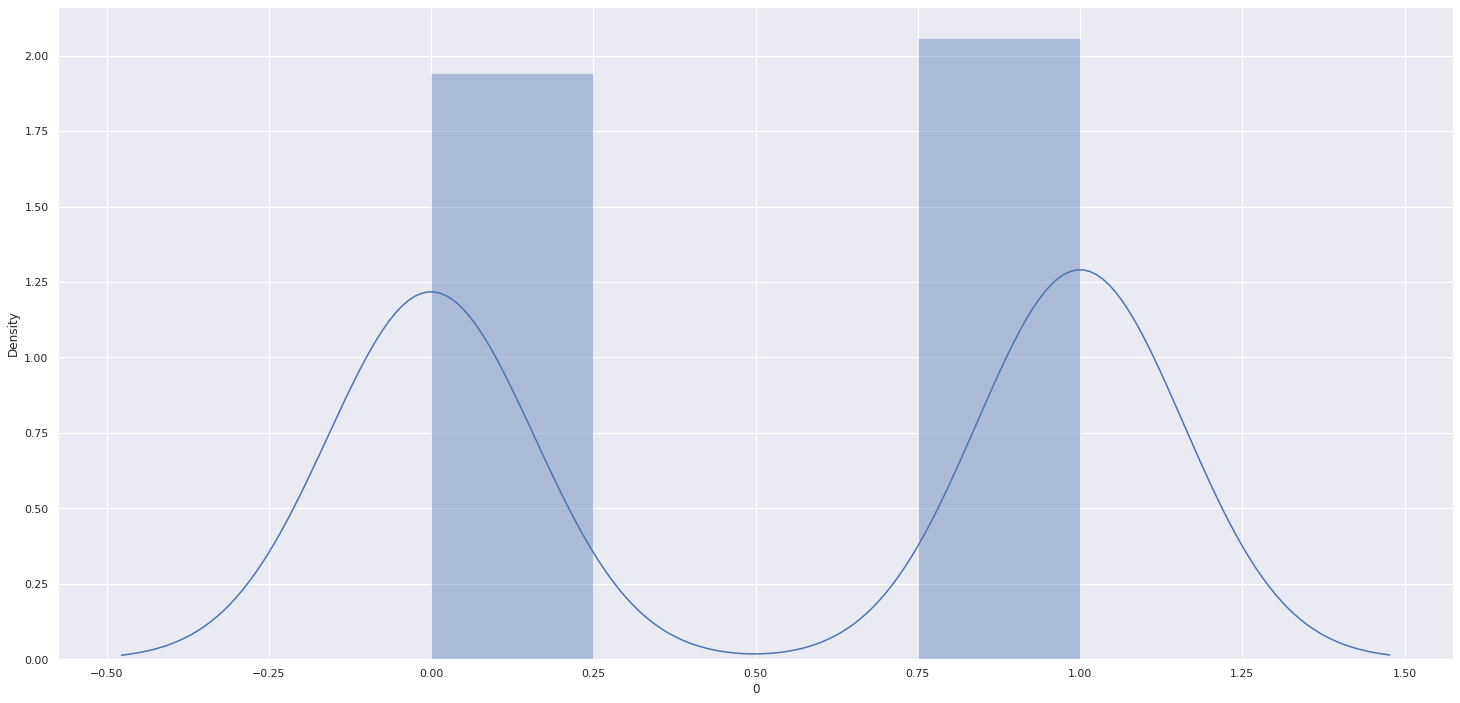

In [109]:
sns.distplot( df3[0] );

**Existe um leve desbalanceio da target response, porém nada muito significante, afim de evitar um bias, não será feito um balanceamento do data.**

## 3.2 Numerical Variables

**1) Depois de analisar os dados, resolvi investigar as colunas, randomicamente, afim de achar um padrão em comum**

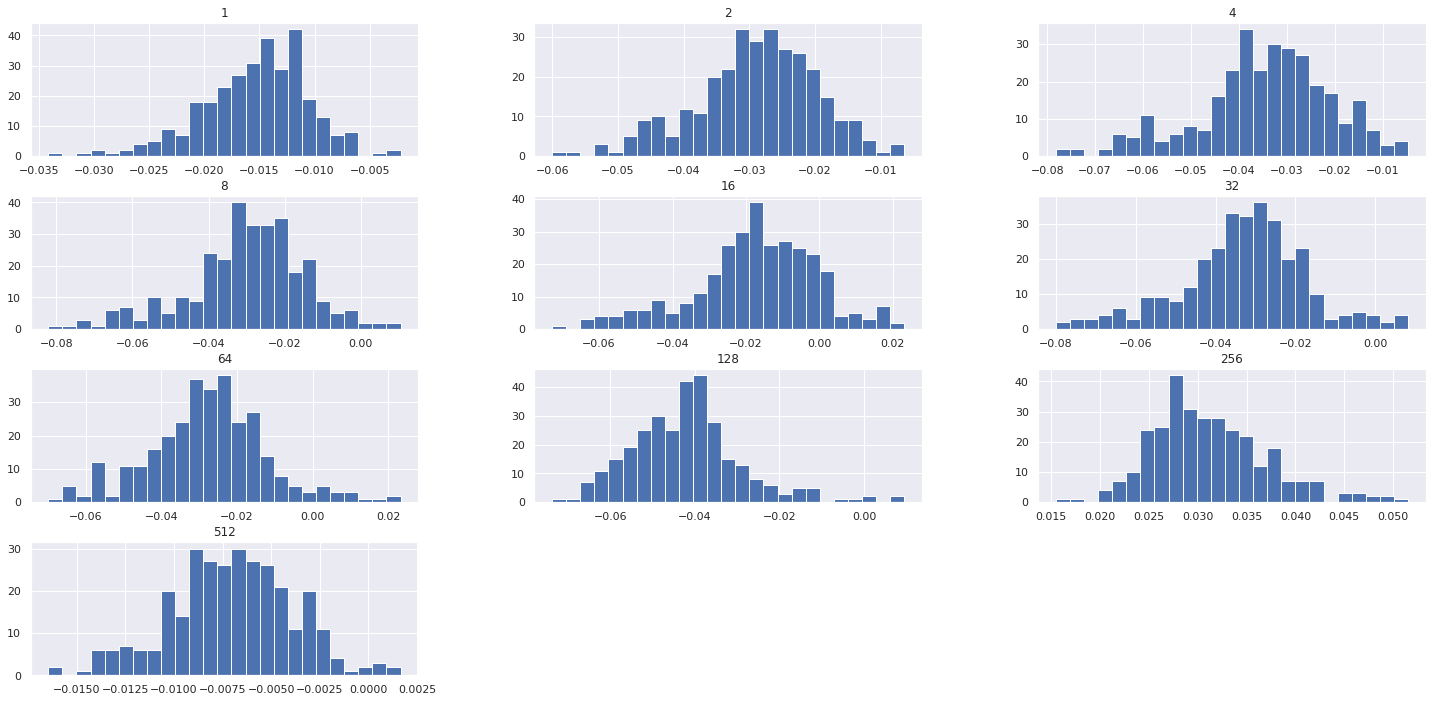

In [110]:
df3[[2 ** x for x in range(10)]].hist( bins=25 );

**2) Nova tentativa, de investigar sobre o dataset**

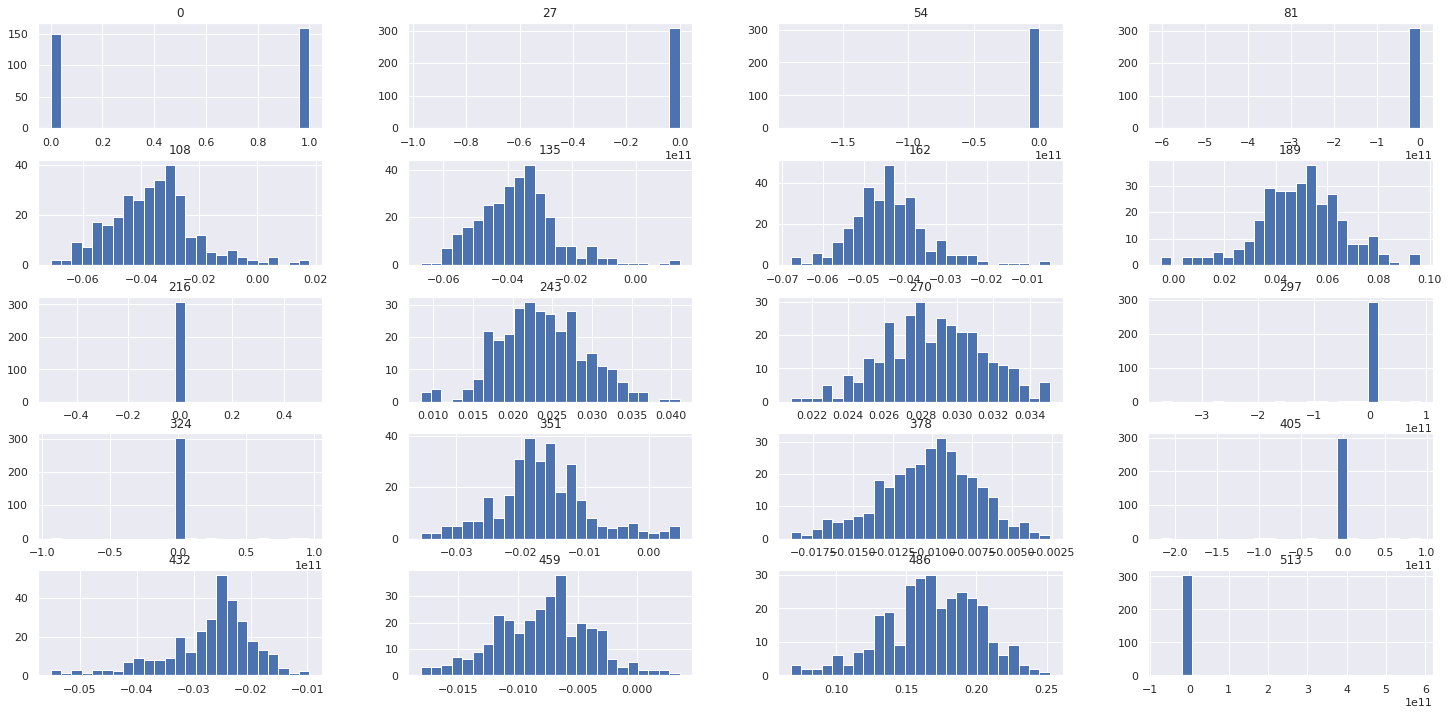

In [111]:
df3[[27 * x for x in range(20)]].hist( bins=25 );

**3) Como apareceram algumas colunas estranhas eu resolvi ver melhor como então destribuidas**

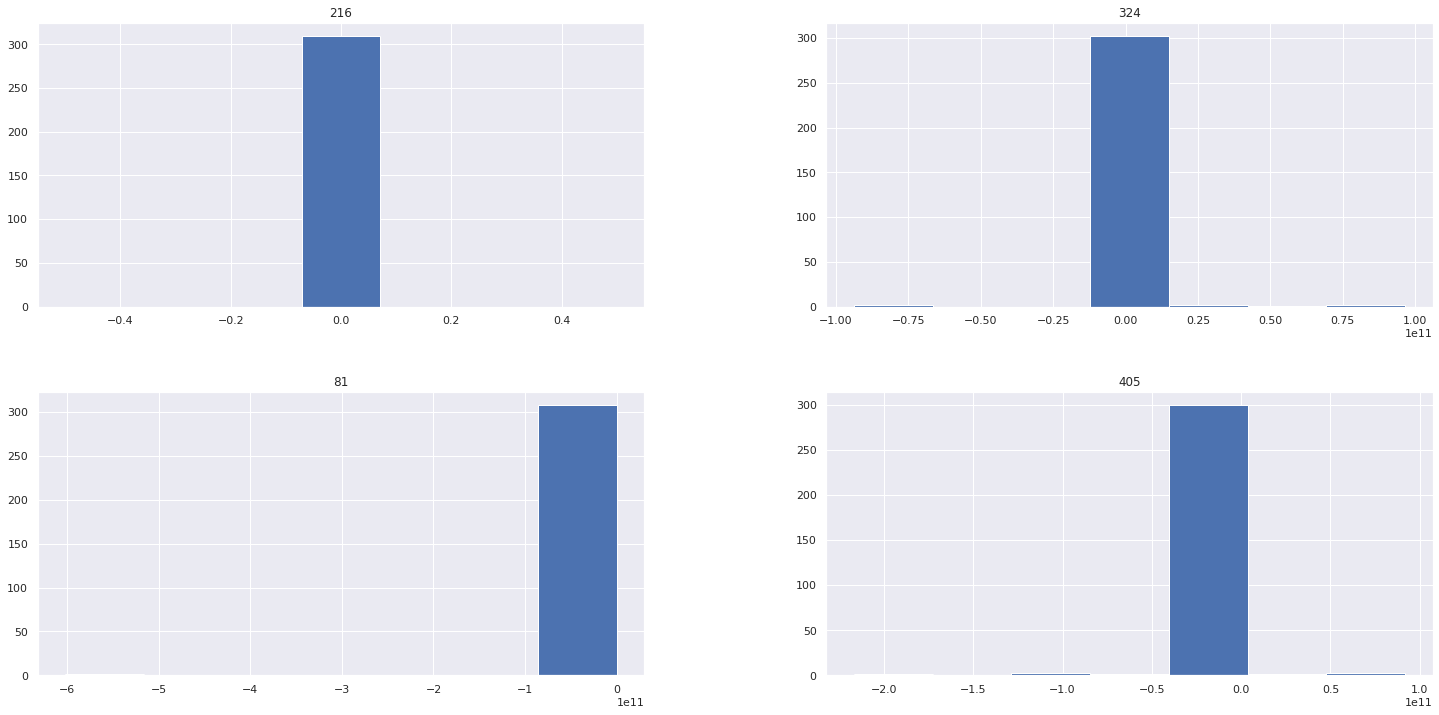

In [112]:
df3[[216, 324, 81, 405]].hist( bins=7 );

**4) Comparativo das Colunas entre as 2 classes:**

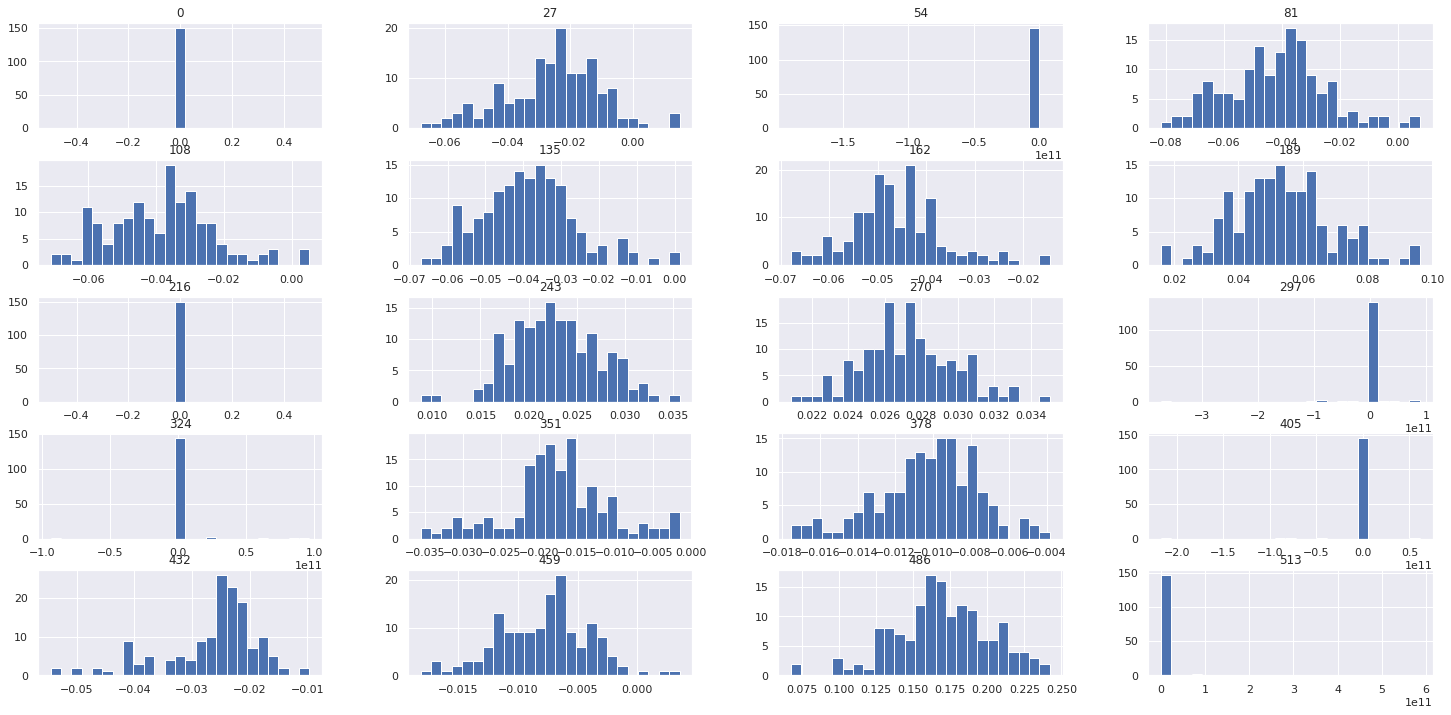

In [113]:
# Controle
aux0 = df3[df3[0] == 0].copy()
aux0[[27 * x for x in range(20)]].hist( bins=25 );

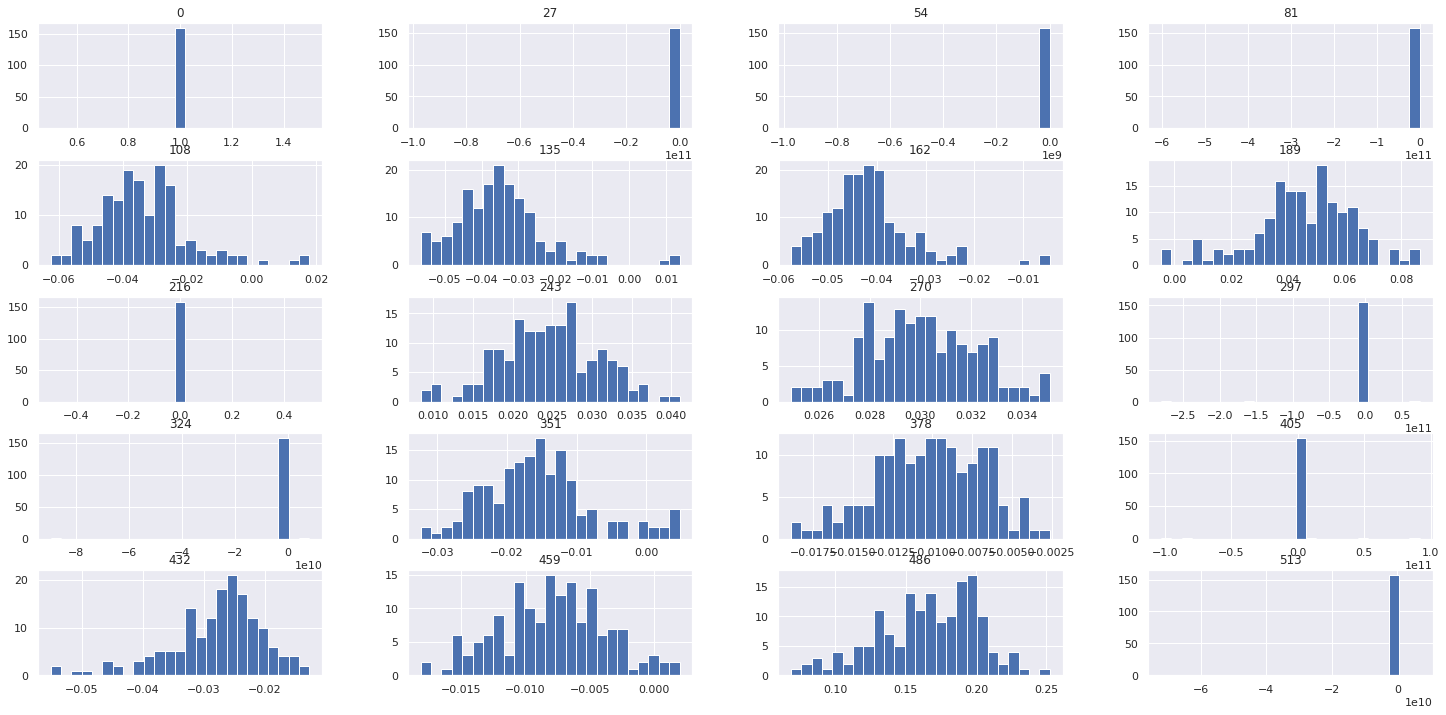

In [114]:
# Covid
aux = df3[df3[0] == 1].copy()
aux[[27 * x for x in range(20)]].hist( bins=25 );

**5) Plotando essas colunas que apresentam um corportamento anômalos entre as classes:**

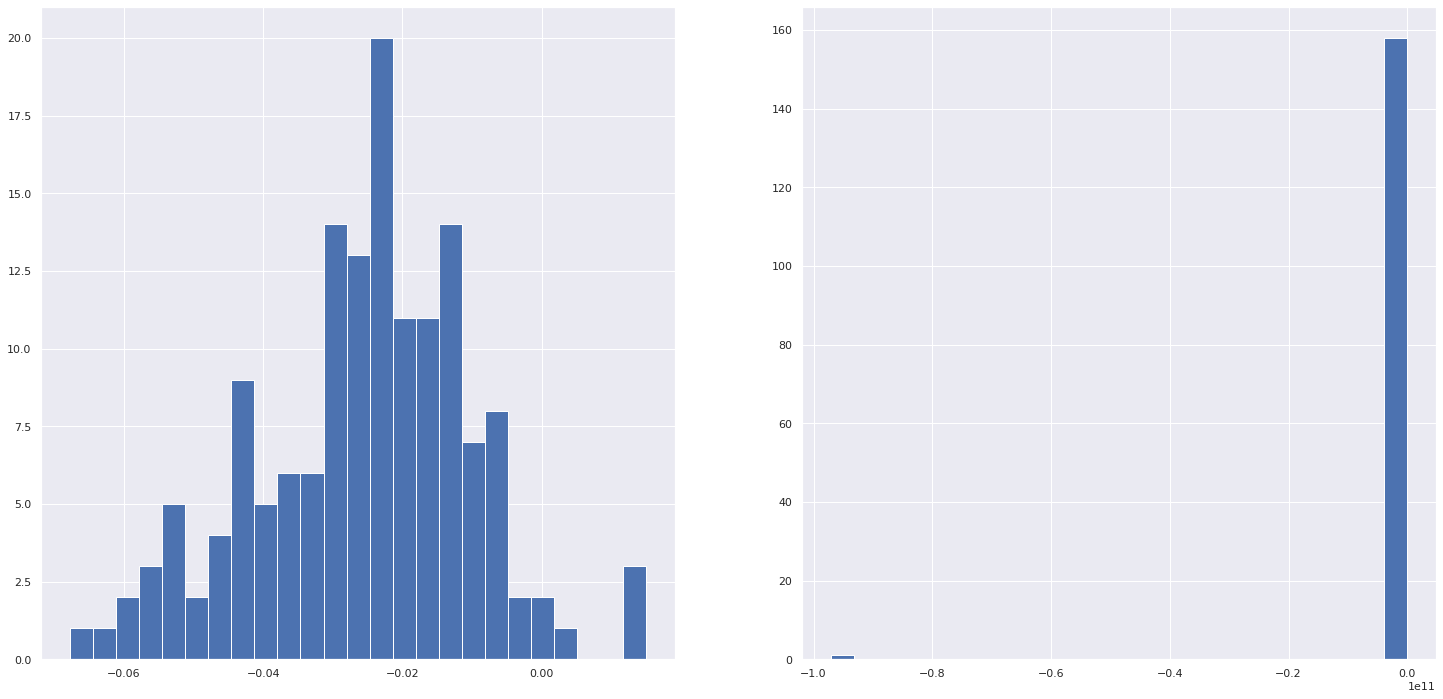

In [115]:
aux00 = df3.loc[df3[0] == 0, 27]
plt.subplot( 1, 2, 1 )
aux00.hist( bins=25 );


aux01 = df3.loc[df3[0] == 1, 27]
plt.subplot( 1, 2, 2 )
aux01.hist( bins=25 );

# INSIGHT !!

**O Insight**

*   **Os valores representam as faixas de frequência do NIR impostas sobre a amostra (linhas) que sofrem reflexão.**

*   **Em algumas faixas (colunas), observa-se que o comportamento de ambas classes permanece o mesmo, com leves divergências entre si.**

*   **Em outras faixas, observa-se que o comportamento de ambas classes são totalmente contrárias.**

*   **Sendo que a de Controle (Class 0) apresenta uma dispersão do feixe que incide sobre a amostra, com uma distribuição próxima da binomial.**

*   **Enquanto a de Covid (Class 1) apresenta uma concentração dos dados em torno do eixo y.**

*   **Provavelmente serão essas colunas que darão a modelagem do fenômeno observado!!**

# 4.0 DATA PREPARATION

In [116]:
df4 = df3.copy()

## 4.1 Rescaling

In [117]:
# Subtrai a média do valor original e divide pelo desvio padrão X_TRAIN
for i in range( df4.shape[1] - 1 ):
    rescaler = pp.StandardScaler().fit( df4[[i+1]] )
    df4[i+1] = rescaler.transform( df4[[i+1]] )

## 4.2 Data Split 

In [118]:
# Separei a response feature das demais features
X = df4.drop( 0, axis=1 ).copy()
y = df4[0].copy()

In [119]:
# SpLiT !!
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = ms.train_test_split( X, y, test_size=0.2, shuffle=True, stratify=y )

In [120]:
# Concat
df4 = pd.concat( [X_TRAIN, Y_TRAIN], axis=1 )

# 5.0 FEATURE SELECTION

In [121]:
df5 = df4.copy()

In [122]:
x_train_n = X_TRAIN.copy()
y_train_n = Y_TRAIN.copy()

## 5.1 Feature Importance

In [123]:
# defining RandomForestClassifier and fitting it
model = RandomForestClassifier().fit( x_train_n, y_train_n )

# get importance
importance = model.feature_importances_

# summarize feature importance
# for i,v in enumerate( importance ):
    # print('Feature: %0d, Score: %.5f' % ( i+1, v ) )

# plot feature importance
feat_imp = pd.DataFrame( {'feature': x_train_n.columns,
                          'feature_importance': importance} ).sort_values( 'feature_importance', ascending=False ).reset_index( drop=True )

feat_imp.head(50).T
# sns.barplot( x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue' );

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
feature,878.00000,875.000000,879.000000,877.000000,782.000000,880.000000,876.000000,851.000000,881.000000,780.000000,852.000000,835.000000,662.000000,254.000000,799.000000,766.000000,763.000000,818.000000,874.000000,850.000000,599.000000,832.000000,167.000000,676.000000,853.000000,816.000000,833.000000,857.000000,253.000000,858.000000,882.000000,831.00000,856.000000,829.000000,661.000000,270.000000,675.000000,887.000000,358.000000,602.000000,690.000000,255.000000,798.000000,814.00000,854.000000,603.000000,212.000000,601.000000,646.000000,836.000000
feature_importance,0.04327,0.032097,0.030576,0.024526,0.021738,0.021014,0.019026,0.017008,0.015773,0.013515,0.012926,0.012782,0.011545,0.011294,0.011035,0.010975,0.010969,0.010695,0.010042,0.009679,0.009353,0.009239,0.009233,0.009033,0.008947,0.008596,0.008358,0.008155,0.008022,0.007681,0.007631,0.00746,0.007221,0.007186,0.006995,0.006595,0.006305,0.006271,0.006236,0.006135,0.005416,0.005412,0.005405,0.00503,0.005012,0.004883,0.004757,0.004732,0.004722,0.004676


## 5.2 Columns Selected

In [124]:
cols_selected = [879, 875, 851, 878, 877, 816, 880, 873, 675, 662, 876, 874, 676, 661, 781, 674, 881, 835, 832, 764, 677]

# 6.0 MACHINE LEARNING MODELING

In [125]:
df6 = df5.copy()

In [126]:
# X_TRAIN = X_TRAIN[[879, 875, 851, 878, 877, 816, 880, 873, 675, 662, 876, 874, 676, 661, 781, 674, 881, 835, 832, 764, 677]]
# X_TEST = X_TEST[[879, 875, 851, 878, 877, 816, 880, 873, 675, 662, 876, 874, 676, 661, 781, 674, 881, 835, 832, 764, 677]]

In [127]:
Y_TEST.unique()

array([1, 0])

## 6.1 Comparing Models

In [128]:
# creating empty dataframes
models_perfor = pd.DataFrame()
metrics = pd.DataFrame()

# models list to be tested
models_list=[KNeighborsClassifier(n_jobs=-1),
             LogisticRegression(penalty='l2', solver='newton-cg'),
             GaussianNB(),
             LGBMClassifier(),
             xgb.XGBClassifier(objective='binary:logistic',
                               eval_metric='error',
                               n_estimators=100,
                               eta=0.01,
                               max_depth=10,
                               subsample=0.7,
                               colsample_bytree=0.9),
             RandomForestClassifier(),
             DecisionTreeClassifier(criterion='entropy', random_state=0)]

In [129]:
m = modeling( models_list, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST )
m.sort_values( 'F1', ascending=False )

KNeighborsClassifier - 0
LogisticRegression - 1
GaussianNB - 2
LGBMClassifier - 3
XGBClassifier - 4
RandomForestClassifier - 5
DecisionTreeClassifier - 6


,Model,ROC AUC,Top K Score,F1,Precision,Recall,Accuracy
1,LogisticRegression - 1,0.99375,0.967742,0.967742,1.0,0.9375,0.967742
3,LGBMClassifier - 3,0.948958,0.935484,0.935484,0.966667,0.90625,0.935484
4,XGBClassifier - 4,0.951042,0.935484,0.935484,0.966667,0.90625,0.935484
5,RandomForestClassifier - 5,0.951562,0.919355,0.920635,0.935484,0.90625,0.919355
6,DecisionTreeClassifier - 6,0.902083,0.903226,0.909091,0.882353,0.9375,0.903226
0,KNeighborsClassifier - 0,0.943229,0.903226,0.903226,0.933333,0.875,0.903226
2,GaussianNB - 2,0.790625,0.806452,0.8125,0.8125,0.8125,0.806452


### 6.1.1 KNNClassifier

In [130]:
# model prediction - Poder de GENERALIZACAO 
knn_model = models_list[0].fit( X_TRAIN, Y_TRAIN )
yhat_proba_knn = knn_model.predict_proba( X_TEST )
yhat_knn = knn_model.predict( X_TEST )
print( classification_report( Y_TEST, yhat_knn ) )

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        30
           1       0.93      0.88      0.90        32

    accuracy                           0.90        62
   macro avg       0.90      0.90      0.90        62
weighted avg       0.91      0.90      0.90        62



### 6.1.2 LogisticRegression

In [131]:
# model prediction - Poder de GENERALIZACAO 
lr_model = models_list[1].fit( X_TRAIN, Y_TRAIN )
yhat_proba_lr = lr_model.predict_proba( X_TEST )
yhat_lr = lr_model.predict( X_TEST )
print( classification_report( Y_TEST, yhat_lr ) )

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       1.00      0.94      0.97        32

    accuracy                           0.97        62
   macro avg       0.97      0.97      0.97        62
weighted avg       0.97      0.97      0.97        62



### 6.1.3 LGBMClassifier

In [132]:
# model prediction - Poder de GENERALIZACAO 
lgbm_model = models_list[3].fit( X_TRAIN, Y_TRAIN )
yhat_proba_lgbm = lgbm_model.predict_proba( X_TEST )
yhat_lgbm = lgbm_model.predict( X_TEST )
print( classification_report( Y_TEST, yhat_lgbm ) )

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.97      0.91      0.94        32

    accuracy                           0.94        62
   macro avg       0.94      0.94      0.94        62
weighted avg       0.94      0.94      0.94        62



### 6.1.4 XGBClassifier

In [133]:
# model prediction - Poder de GENERALIZACAO 
xgb_model = models_list[4].fit( X_TRAIN, Y_TRAIN )
yhat_proba_xgb = xgb_model.predict_proba( X_TEST )
yhat_xgb = xgb_model.predict( X_TEST )
print( classification_report( Y_TEST, yhat_xgb ) )

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.97      0.91      0.94        32

    accuracy                           0.94        62
   macro avg       0.94      0.94      0.94        62
weighted avg       0.94      0.94      0.94        62



### 6.1.5 RandomForestClassifier

In [134]:
# model prediction - Poder de GENERALIZACAO 
rf_model = models_list[5].fit( X_TRAIN, Y_TRAIN )
yhat_proba_rf = rf_model.predict_proba( X_TEST )
yhat_rf = rf_model.predict( X_TEST )
print( classification_report( Y_TEST, yhat_rf ) )

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.97      0.91      0.94        32

    accuracy                           0.94        62
   macro avg       0.94      0.94      0.94        62
weighted avg       0.94      0.94      0.94        62



## 6.2 Comparing Cumulative Curve

### 6.2.1 KNN

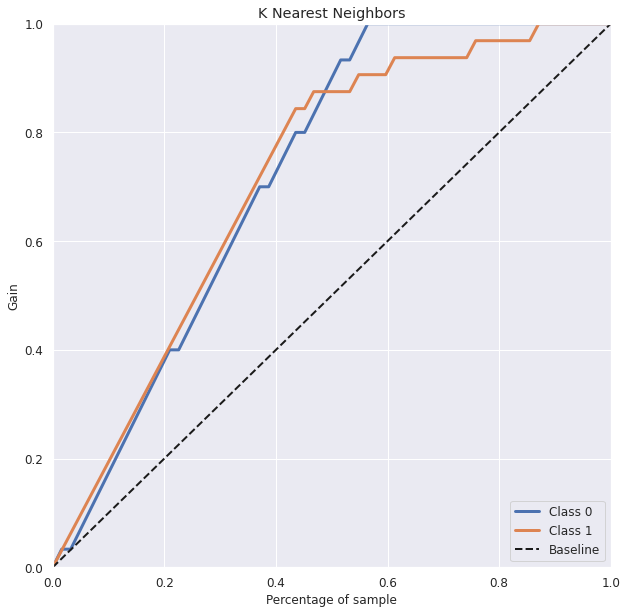

In [135]:
skplt.metrics.plot_cumulative_gain( Y_TEST, yhat_proba_knn, figsize=(10, 10), title='K Nearest Neighbors' );

### 6.2.2 Logistic Regression

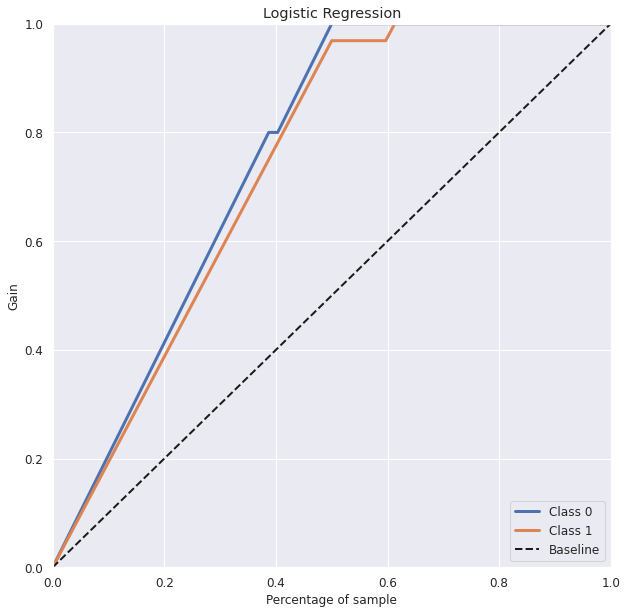

In [136]:
skplt.metrics.plot_cumulative_gain( Y_TEST, yhat_proba_lr, figsize=(10, 10), title='Logistic Regression' );

### 6.2.3 LGBM

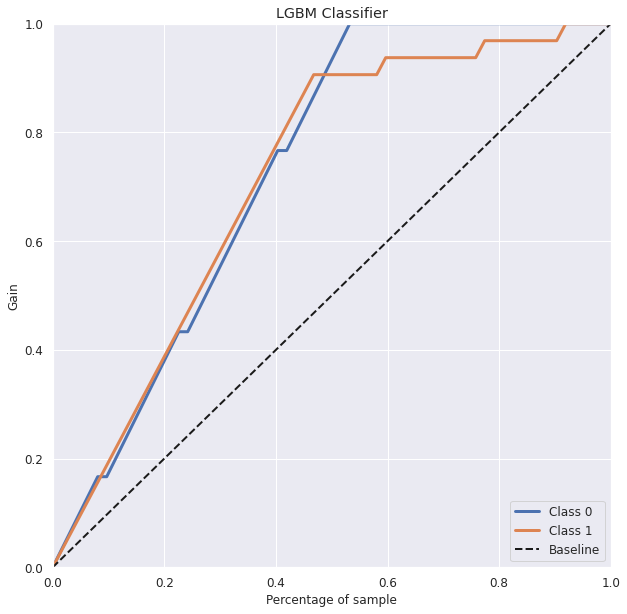

In [137]:
skplt.metrics.plot_cumulative_gain( Y_TEST, yhat_proba_lgbm, figsize=(10, 10), title='LGBM Classifier' );

### 6.2.4 XGBoost

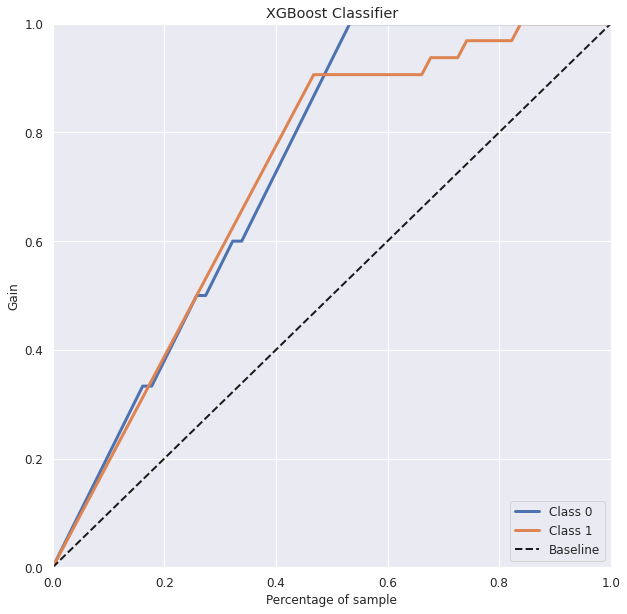

In [138]:
skplt.metrics.plot_cumulative_gain( Y_TEST, yhat_proba_xgb, figsize=(10, 10), title='XGBoost Classifier' );

### 6.2.5 Random Forest

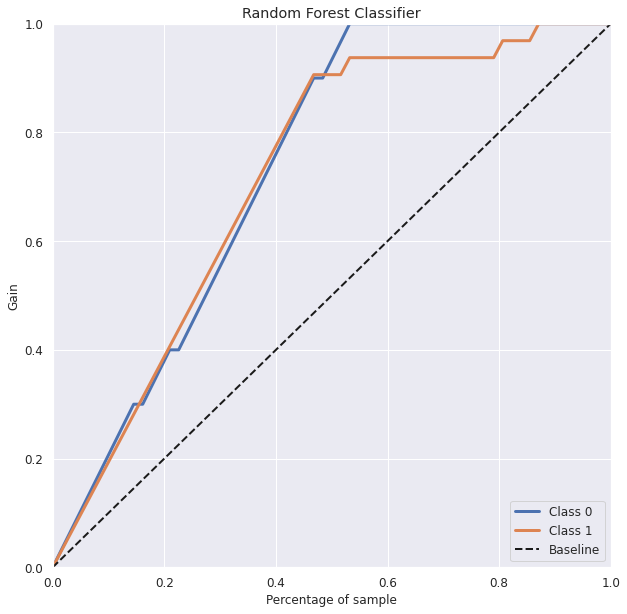

In [139]:
skplt.metrics.plot_cumulative_gain( Y_TEST, yhat_proba_rf, figsize=(10, 10), title='Random Forest Classifier' );

## 6.3 Comparing LIFT Curve

### 6.3.1 KNN

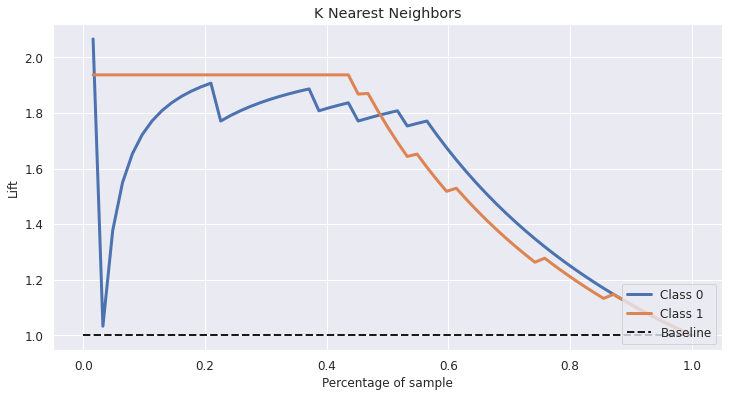

In [140]:
skplt.metrics.plot_lift_curve( Y_TEST, yhat_proba_knn, figsize=(12,6), title='K Nearest Neighbors' );

### 6.3.2 Logistic Regression

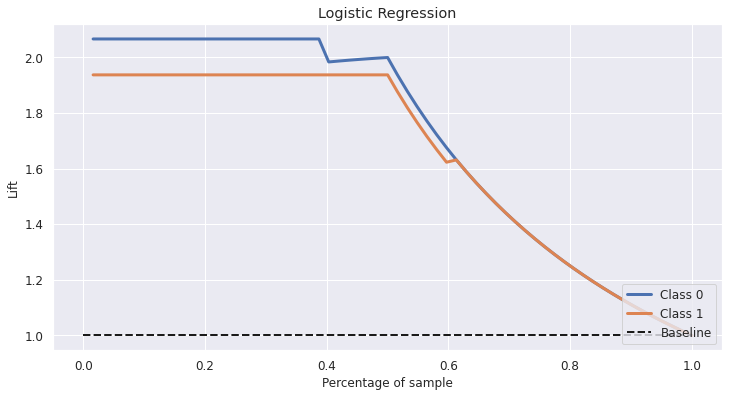

In [141]:
skplt.metrics.plot_lift_curve( Y_TEST, yhat_proba_lr, figsize=(12,6), title='Logistic Regression' );

### 6.3.3 LGBM

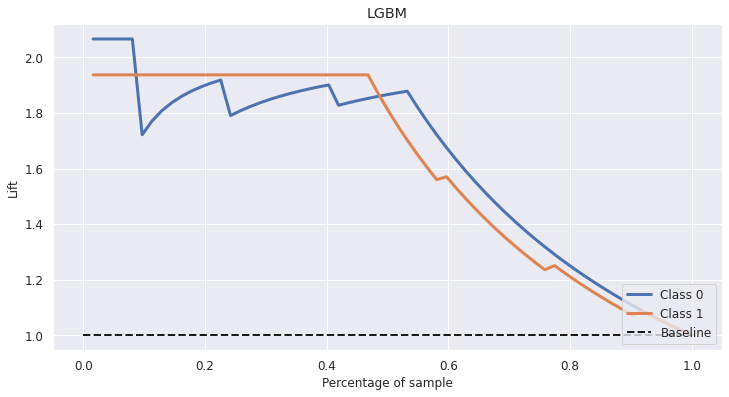

In [142]:
skplt.metrics.plot_lift_curve( Y_TEST, yhat_proba_lgbm, figsize=(12,6), title='LGBM' );

### 6.3.4 XGBoost

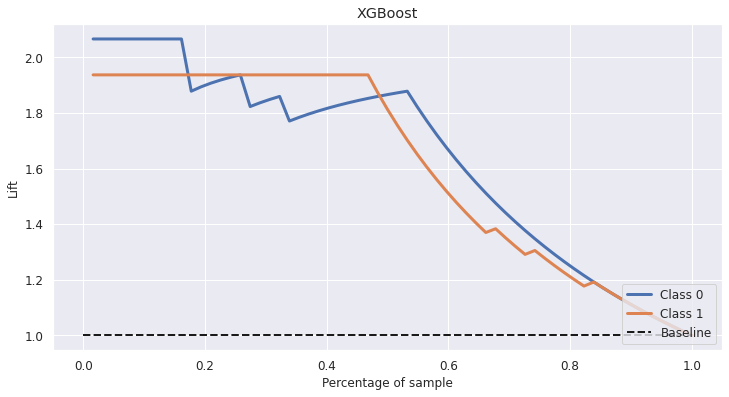

In [143]:
skplt.metrics.plot_lift_curve( Y_TEST, yhat_proba_xgb, figsize=(12,6), title='XGBoost' );

### 6.3.5 Random Forest

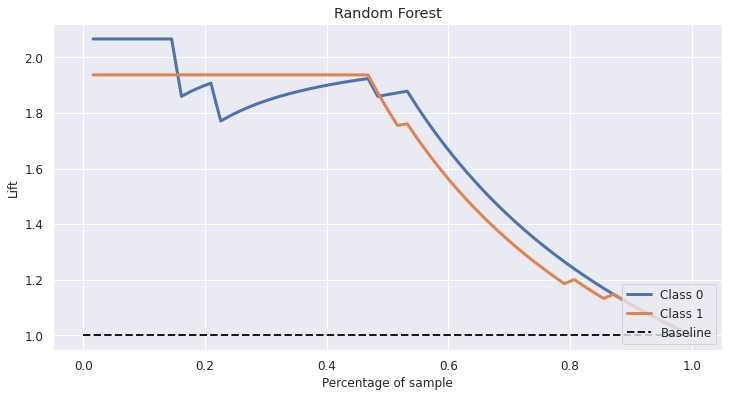

In [144]:
skplt.metrics.plot_lift_curve( Y_TEST, yhat_proba_rf, figsize=(12,6), title='Random Forest' );

# 7.0 CROSS VALIDATION

In [145]:
df7 = df6.copy()
models_performance = pd.DataFrame()
avg_performance = pd.DataFrame()

In [148]:
performance, avg = cross_validation( 'Logistic', models_list[1], X_TRAIN, Y_TRAIN, 10 )
models_performance = models_performance.append( performance )
avg_performance = avg_performance.append( avg )

KFold Number 1/10
KFold Number 2/10
KFold Number 3/10
KFold Number 4/10
KFold Number 5/10
KFold Number 6/10
KFold Number 7/10
KFold Number 8/10
KFold Number 9/10
KFold Number 10/10


In [149]:
avg_performance

,Model,ROC AUC,Top K Score,F1,Precision,Recall,Accuracy
0,Logistic Average,0.980342,0.9515,0.951239,0.984615,0.921154,0.9515


# 8.0 HYPERPARAMETER FINE TUNNING

In [150]:
df8 = df7.copy()
max_eval = 10
me = pd.DataFrame()

In [151]:
knn_parameter = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 'class_weight': ['balanced', None],
                 'n_jobs': [-1]}
                 

In [152]:
# Escolha de parâmetros aleatório
for i in range ( max_eval ):
    hp = {k: rd.sample( v, 1 )[0] for k, v in knn_parameter.items()}
    print( hp )
    model_knn = LogisticRegression( solver = hp['solver'],
                                    class_weight = hp['class_weight'],
                                    n_jobs = hp['n_jobs']).fit( X_TRAIN, Y_TRAIN ) 
                                                                  
    ma = modeling( [model_knn], X_TRAIN, Y_TRAIN, X_TEST, Y_TEST, False )
    me = pd.concat( [me, ma] )
me.reset_index().drop( ['index'], axis=1 )

{'solver': 'lbfgs', 'class_weight': None, 'n_jobs': -1}
{'solver': 'saga', 'class_weight': 'balanced', 'n_jobs': -1}
{'solver': 'newton-cg', 'class_weight': 'balanced', 'n_jobs': -1}
{'solver': 'newton-cg', 'class_weight': None, 'n_jobs': -1}
{'solver': 'saga', 'class_weight': None, 'n_jobs': -1}
{'solver': 'lbfgs', 'class_weight': 'balanced', 'n_jobs': -1}
{'solver': 'lbfgs', 'class_weight': None, 'n_jobs': -1}
{'solver': 'sag', 'class_weight': None, 'n_jobs': -1}
{'solver': 'newton-cg', 'class_weight': 'balanced', 'n_jobs': -1}
{'solver': 'saga', 'class_weight': None, 'n_jobs': -1}


,Model,ROC AUC,Top K Score,F1,Precision,Recall,Accuracy
0,LogisticRegression - 0,0.99375,0.967742,0.967742,1.0,0.9375,0.967742
1,LogisticRegression - 0,0.994792,0.951613,0.95082,1.0,0.90625,0.951613
2,LogisticRegression - 0,0.99375,0.967742,0.967742,1.0,0.9375,0.967742
3,LogisticRegression - 0,0.99375,0.967742,0.967742,1.0,0.9375,0.967742
4,LogisticRegression - 0,0.994792,0.951613,0.95082,1.0,0.90625,0.951613
5,LogisticRegression - 0,0.99375,0.967742,0.967742,1.0,0.9375,0.967742
6,LogisticRegression - 0,0.99375,0.967742,0.967742,1.0,0.9375,0.967742
7,LogisticRegression - 0,0.994792,0.967742,0.967742,1.0,0.9375,0.967742
8,LogisticRegression - 0,0.99375,0.967742,0.967742,1.0,0.9375,0.967742
9,LogisticRegression - 0,0.994792,0.951613,0.95082,1.0,0.90625,0.951613


# 9.0 FINAL MODEL

Aqui eu optei por Logistic Regression como modelo para modelar nosso fenômeno de classificação, visto que suas Cumulative Curve e LIFT Curve apresentam um desempenho melhor que os demais modelos e as outras métricas também nos diz que o modelo está muito bem estruturado.

In [153]:
# model prediction - Poder de GENERALIZACAO 
lr_model = LogisticRegression( solver = 'saga',
                               class_weight = None,
                               n_jobs = -1).fit( X_TRAIN, Y_TRAIN )
yhat_proba_lr = lr_model.predict_proba( X_TEST )
yhat_lr = lr_model.predict( X_TEST )

In [156]:
pickle.dump( lr_model, open( '/content/drive/MyDrive/Colab/data/pcr_covid_tester_nir/Logistic_Model.pkl' , 'wb' ) )

In [157]:
models_performance = pd.DataFrame()
avg_performance = pd.DataFrame()

performance, avg = cross_validation( 'Logistic', lr_model, X_TRAIN, Y_TRAIN, 10 )
models_performance = models_performance.append( performance )
avg_performance.append( avg )

KFold Number 1/10
KFold Number 2/10
KFold Number 3/10
KFold Number 4/10
KFold Number 5/10
KFold Number 6/10
KFold Number 7/10
KFold Number 8/10
KFold Number 9/10
KFold Number 10/10


,Model,ROC AUC,Top K Score,F1,Precision,Recall,Accuracy
0,Logistic Average,0.983707,0.9475,0.945957,0.990909,0.905769,0.9475


## 9.1 Cumulative Curve

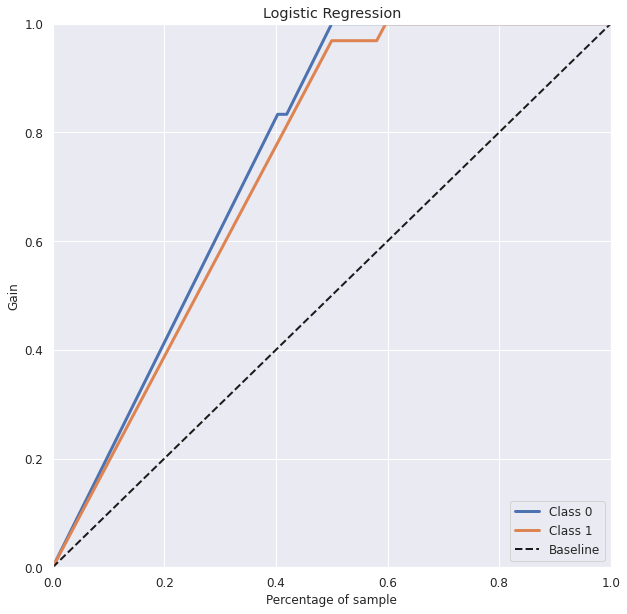

In [158]:
skplt.metrics.plot_cumulative_gain( Y_TEST, yhat_proba_lr, figsize=(10, 10), title='Logistic Regression' );

## 9.2 LIFT Curve

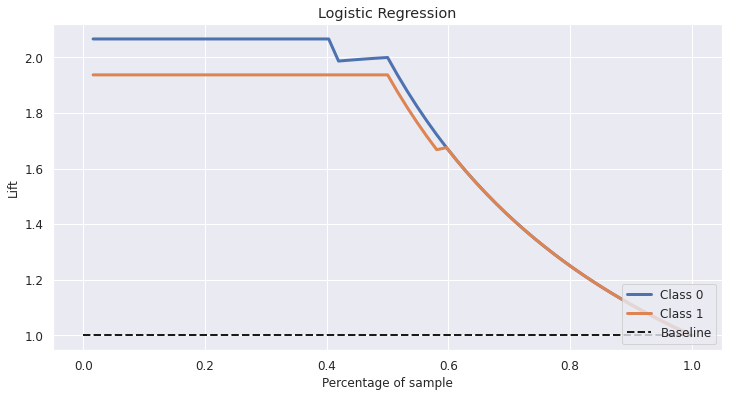

In [159]:
skplt.metrics.plot_lift_curve( Y_TEST, yhat_proba_lr, figsize=(12,6), title='Logistic Regression' );

Vamos agora calcular algumas 

In [160]:
x_test = X_TEST.copy()

In [161]:
x_test.shape

(62, 899)

In [162]:
x_test['score_proba_logistic'] = yhat_proba_lr[:,1].tolist()
x_test['target_predict'] = yhat_lr.tolist()
x_test['true_response'] = Y_TEST.copy()

# k -- AMOSTRAGEM DOS DADOS
k = 31

# perc -- PERCENTAGEM DOS DATASET DE TESTE ORIGINAL
perc = k / x_test.shape[0]

# target_at_k -- ORDENA O SCORE DE CADA MODELO, SELECIONA OS "K" PRIMEIROS E CONTA QUANTOS SÃO TRUE POSITIVE
target_at_k = x_test.sort_values('score_proba_logistic', ascending=False)[:k]
target_at_k = target_at_k[( target_at_k['true_response'] == 1 ) & ( target_at_k['target_predict'] == 1 )]['true_response'].sum()

# target_total -- TODOS OS TRUE_RESPONSE = 1 DOS DADO  OUTPUT = 9342
target_total = x_test[( x_test['true_response'] == 1 ) & ( x_test['target_predict'] == 1 )]['true_response'].sum()

# perc_target -- target_at_tk DIVIDIDO POR target_total
perc_target = target_at_k/target_total
perc_target = perc_target*100
print( 'Para {} primeiros valores de amostragem nosso modelo conseguiu classificar {} como class Covid'.format( k, target_at_k ) )
print( 'Nosso "x_test" total (62) contém ao todo {} amostragens da classe Covid, ou seja,'.format( target_total ) )
print( 'o valor do "recall_at_{}" que o nosso modelo conseguiu classificar verdadeiramente, a classe covid, entre todos os "true_response" das amostras, foi de {}%'.format( k, perc_target ) )
# perc

Para 31 primeiros valores de amostragem nosso modelo conseguiu classificar 29 como class Covid
Nosso "x_test" total (62) contém ao todo 29 amostragens da classe Covid, ou seja,
o valor do "recall_at_31" que o nosso modelo conseguiu classificar verdadeiramente, a classe covid, entre todos os "true_response" das amostras, foi de 100.0%


# 10.0 QUESTÕES DE NEGÓCIO

Como se comportam as metricas Precision e Recall dada uma porcentagem desse dataset de test

In [163]:
proba = [yhat_proba_lr]
perc = [0.01, 0.1, 0.2, 0.4, 0.5]

In [164]:
df_final = top_k_performance( x_test, proba, perc )
df_final[['Model', 'perc', 'k', 'precision', 'recall']]

,Model,perc,k,precision,recall
0,Logistic Regression,0.01,0.0,0.999946,0.032984
1,Logistic Regression,0.10,6.0,0.999733,0.230841
2,Logistic Regression,0.20,12.0,0.998972,0.428378
3,Logistic Regression,0.40,24.0,0.993638,0.819406
4,Logistic Regression,0.50,31.0,0.921263,0.972444


Aqui, tentei elaborar uma questão de negócio, como por exemplo:

*   A Empresa recebe 100 reais por cada teste que dê positivo, qual retorno financeiro para a empresa em relação ao modelo randômico de classificação?

*   A Empresa recebe valores diferentes para cada classe predita, qual retorno financeiro esperado?

Mas como não tenho conhecimentos suficientes ainda sobre o modelo de negócio da empresa, resolvi deixar para o próximo ciclo.

# 11.0 DEPLOY DO MODELO

## 11.1 DersalisNIR Class

In [167]:
import pickle
import pandas as pd
import numpy as np

class PCRCovidTesterNIR( object ):
  def __init__( self ):
    self.home_path = ''
    self.scaler_879 = pickle.load( open( self.home_path + 'scaler_879.pkl','rb' ) )
    self.scaler_875 = pickle.load( open( self.home_path + 'scaler_875.pkl','rb' ) )
    self.scaler_851 = pickle.load( open( self.home_path + 'scaler_851.pkl','rb' ) )
    self.scaler_878 = pickle.load( open( self.home_path + 'scaler_878.pkl','rb' ) )
    self.scaler_877 = pickle.load( open( self.home_path + 'scaler_877.pkl','rb' ) )
    self.scaler_816 = pickle.load( open( self.home_path + 'scaler_816.pkl','rb' ) )
    self.scaler_880 = pickle.load( open( self.home_path + 'scaler_880.pkl','rb' ) )
    self.scaler_873 = pickle.load( open( self.home_path + 'scaler_873.pkl','rb' ) )
    self.scaler_675 = pickle.load( open( self.home_path + 'scaler_675.pkl','rb' ) )
    self.scaler_662 = pickle.load( open( self.home_path + 'scaler_662.pkl','rb' ) )
    self.scaler_876 = pickle.load( open( self.home_path + 'scaler_876.pkl','rb' ) )
    self.scaler_874 = pickle.load( open( self.home_path + 'scaler_874.pkl','rb' ) )
    self.scaler_676 = pickle.load( open( self.home_path + 'scaler_676.pkl','rb' ) )
    self.scaler_661 = pickle.load( open( self.home_path + 'scaler_661.pkl','rb' ) )
    self.scaler_781 = pickle.load( open( self.home_path + 'scaler_781.pkl','rb' ) )
    self.scaler_674 = pickle.load( open( self.home_path + 'scaler_674.pkl','rb' ) )
    self.scaler_881 = pickle.load( open( self.home_path + 'scaler_881.pkl','rb' ) )
    self.scaler_835 = pickle.load( open( self.home_path + 'scaler_835.pkl','rb' ) )
    self.scaler_832 = pickle.load( open( self.home_path + 'scaler_832.pkl','rb' ) )
    self.scaler_764 = pickle.load( open( self.home_path + 'scaler_764.pkl','rb' ) )
    self.scaler_677 = pickle.load( open( self.home_path + 'scaler_677.pkl','rb' ) )
    
    
  def data_cleaning( self, df ):
    df = df
    return df

  def feature_engineering( self, df ):
    # Replacing "," to "."
    for i in range ( df.shape[1] ):
      df[i] = df[i].apply( lambda x: x.replace( ',', '.' ) )

    # Converting Target Variable to 0 and 1
    # Control = 0, Covid = 1
    df[0] = df[0].apply( lambda x: 0 if x == 'Control' else 1 )

    # Transform float (exclude = df[0])
    for i in range ( df.shape[1] - 1 ):
      df[i+1] = df[i+1].astype( 'float64' )

    return df

  def data_preparation( self, df ):
    # 879
    df[879] = self.scaler_879.transform( df[[879]].values )

    # 875
    df[875] = self.scaler_875.transform( df[[875]].values )

    # 851
    df[851] = self.scaler_851.transform( df[[851]].values )

    # 878
    df[878] = self.scaler_878.transform( df[[878]].values )

    # 877
    df[877] = self.scaler_877.transform( df[[877]].values )

    # 816
    df[816] = self.scaler_816.transform( df[[816]].values )

    # 880
    df[880] = self.scaler_880.transform( df[[880]].values )

    # 873
    df[873] = self.scaler_879.transform( df[[873]].values )

    # 675
    df[675] = self.scaler_675.transform( df[[675]].values )

    # 662
    df[662] = self.scaler_662.transform( df[[662]].values )

    # 876
    df[876] = self.scaler_876.transform( df[[876]].values )

    # 874
    df[874] = self.scaler_874.transform( df[[874]].values )

    # 676
    df[676] = self.scaler_676.transform( df[[676]].values )

    # 661
    df[661] = self.scaler_661.transform( df[[661]].values )

    # 781
    df[781] = self.scaler_781.transform( df[[781]].values )

    # 674
    df[674] = self.scaler_674.transform( df[[674]].values )

    # 881
    df[881] = self.scaler_881.transform( df[[881]].values )

    # 835
    df[835] = self.scaler_835.transform( df[[835]].values )

    # 832
    df[832] = self.scaler_832.transform( df[[832]].values )

    # 764
    df[764] = self.scaler_764.transform( df[[764]].values )

    # 677
    df[677] = self.scaler_677.transform( df[[677]].values )
    
    return df[879, 875, 851, 878, 877, 816, 880, 873, 675, 662, 876, 874, 676, 661, 781, 674, 881, 835, 832, 764, 677]
    
  def get_prediction( self, model, original_data, test_data ):
    # model prediction
    pred = model.predict( test_data )

    # join prediction into original_data
    original_data['target_predict'] = pred.tolist()

    # define threshold if necessary
    # self.threshold = lambda x: 0 if x < 0.33 else original_data['target_predict']
    # original_data.loc[:, 'target_predict'] = original_data['target_predict'].map( self.threshold )
    
    # sort_values
    original_data = original_data.sort_values( 'target_predict', ascending = False )

    return original_data.to_json( orient='records', data_format='iso')

## 11.2 API Handler

In [168]:
from crypt import methods
import os
import pickle
import pandas as pd
from flask import Flask, request, Response
from pcrcovidtester import PCRCovidTesterNIR

# loading model
model = pickle.load( open( 'model/Logistic_Model.pkl','rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def healthinsurance_predict():
    test_json = request.get_json()
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique exemple
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple exemples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate PCRCovidTesterNIR Class
        pipeline = PCRCovidTesterNIR()
        
        # data cleaning
        df = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df = pipeline.feature_engineering( df )
        
        # data preparation
        df = pipeline.data_preparation( df )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    port = os.environ.get( 'PORT', 5000 )
    app.run( '0.0.0.0', port=port )
